In [175]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(color_codes=True)
sns.set(context='talk')


# this is horrible voodoo to get deprecation warnings to stop
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn


# a function to get predictions so we can plot true mullen vs predicted mullen
def get_held_outpredictions(X, estimators, splits):
    y_est = np.zeros(len(X))
    for i, (train_inds, test_inds) in enumerate(splits):
        estimator = estimators[i]
        y_est[test_inds] = estimator.predict(pd.DataFrame(X[test_inds, :]))
    return y_est


# function to scatter plot the true mullens vs estimates
def plot_scatter(y_true, y_est, months, model):
    plt.figure(figsize=(12, 12))
    straight_line = np.linspace(y_true.min() * 0.95, y_true.max() * 1.05, 100)
    plt.plot(straight_line, straight_line, alpha=0.25, c='r')
    plt.scatter(y_true, y_est, alpha=0.75)
    plt.xlabel('Average Raw Mullen Score')
    plt.ylabel('Predicted Average Raw Mullen Score')
    plt.xlim(y_true.min() * 0.95, y_true.max() * 1.05)
    plt.ylim(y_true.min() * 0.95, y_true.max() * 1.05)
    plt.title(f'Model = {model}, Months = {months}, R^2 = {np.round(r2_score(y_true, y_est), 2)}')
    #plt.title(f'Model = {model}, Months = {months}, Pearson R = {np.round(pearsonr(y_true, y_est)[0], 2)}')

    
# load data
with open("data/processed_data.pickle", "rb") as f:
    (
        df_crypto,
        crypto_output_6_covariates,
        crypto_input_6_covariates,
        crypto_output_24_covariates,
        crypto_input_24_covariates,
        df_provide,
        provide_output_36_covariates,
        provide_input_36_covariates,
        provide_output_60_covariates,
        provide_input_60_covariates,
        names_of_covariate_groups
    ) = pickle.load(f)

# load results and models
with open('data/ml_results.pickle', 'rb') as f:
    all_results = pickle.load(f)

In [176]:
def drop_the_right_rows(df, output_covariate, covariates_to_check='raw_fnirs'):
    # first drop the rows where there is no output
    df = df.copy()
    df = df.loc[~pd.isnull(df[output_covariate]), :]
    # now drop rows where all of the fnirs are missing
    covariate_missing_flag = df[covariates_to_check].isnull().all(1)
    df = df.loc[~covariate_missing_flag, :]
    return df

<Figure size 1152x720 with 0 Axes>

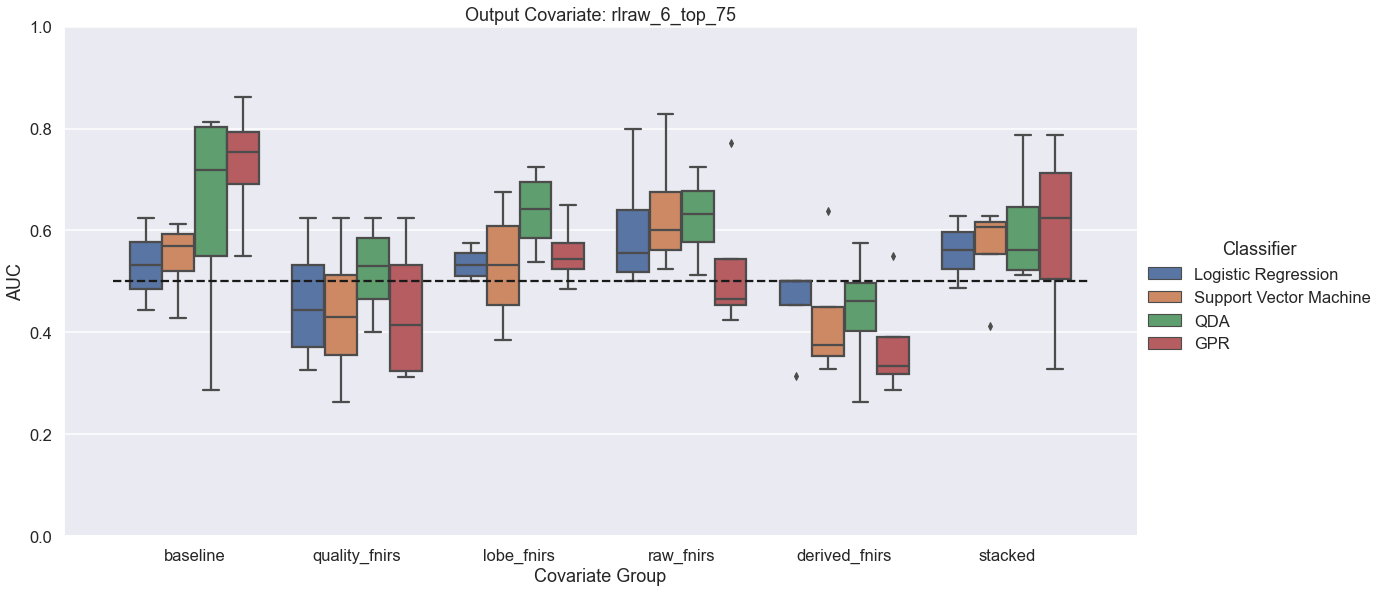

<Figure size 1152x720 with 0 Axes>

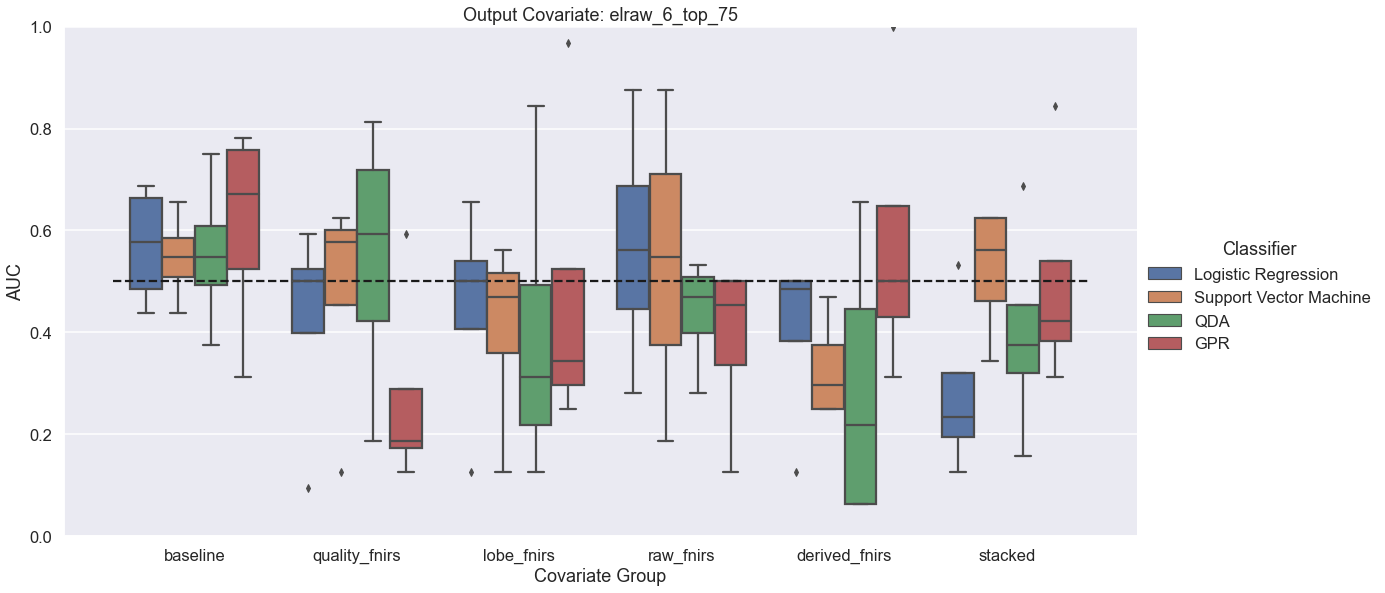

<Figure size 1152x720 with 0 Axes>

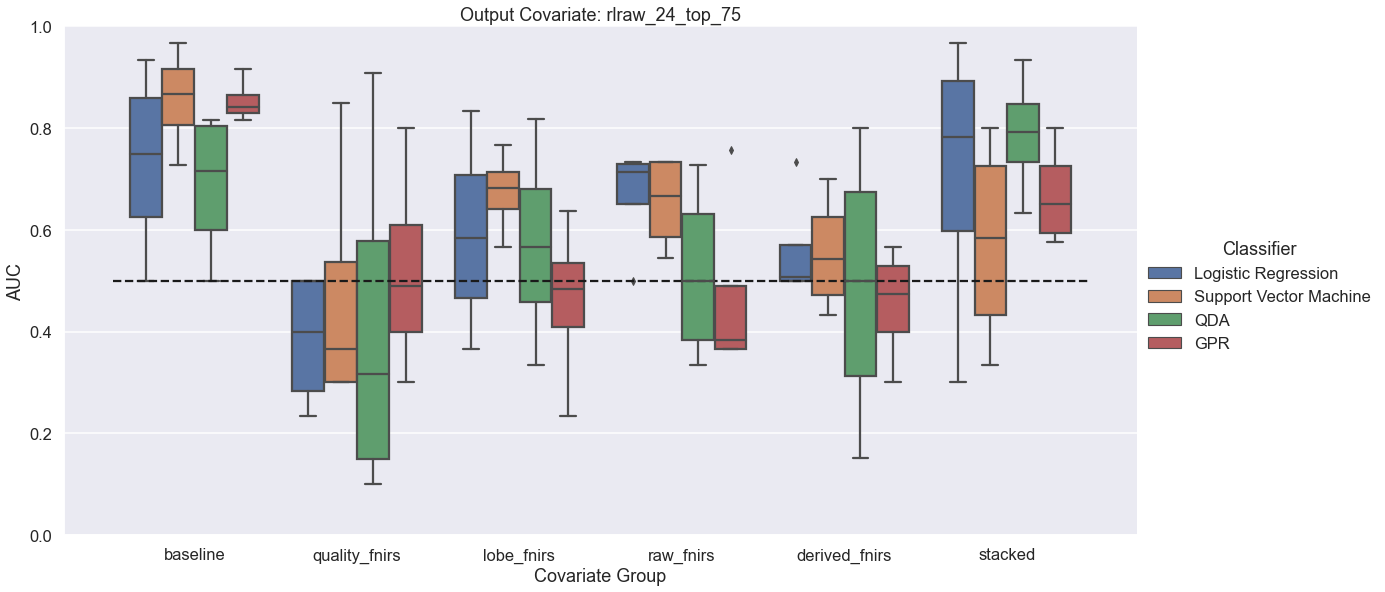

<Figure size 1152x720 with 0 Axes>

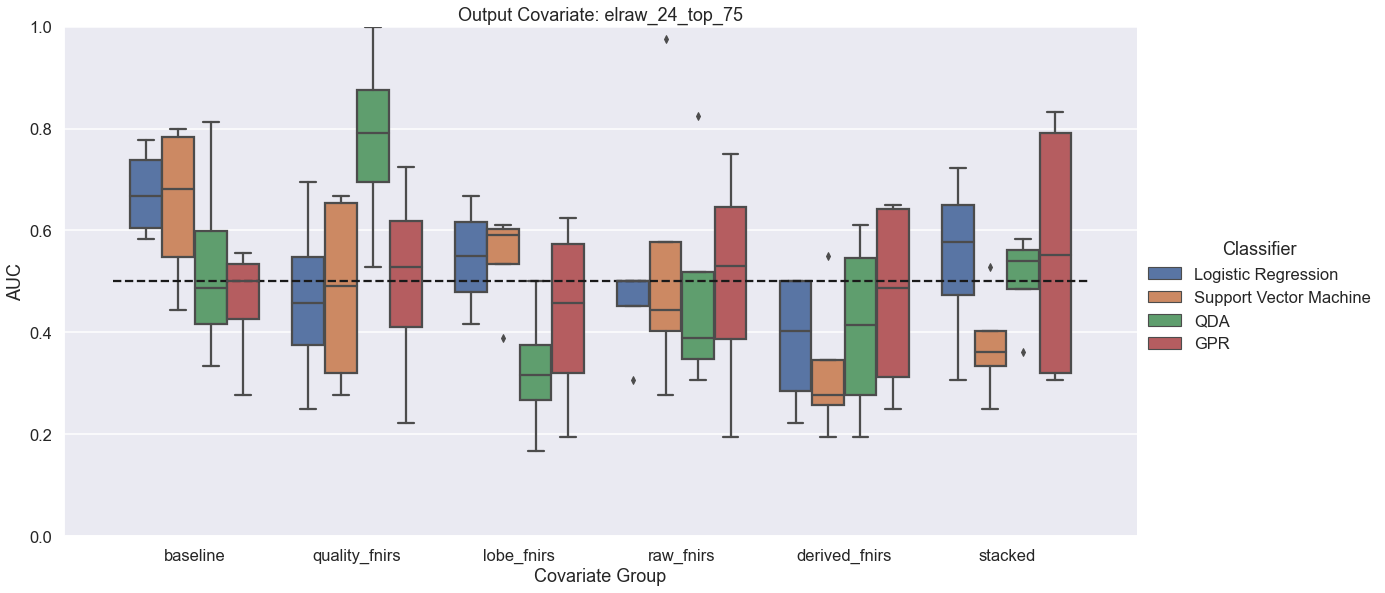

<Figure size 1152x720 with 0 Axes>

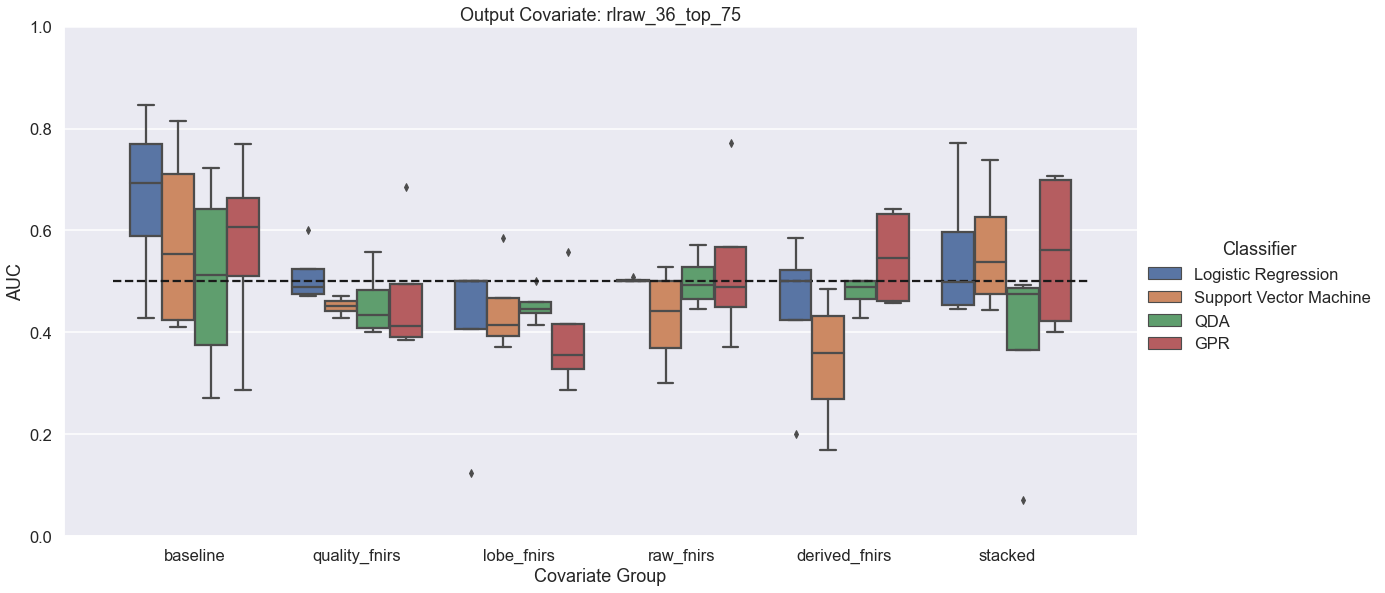

<Figure size 1152x720 with 0 Axes>

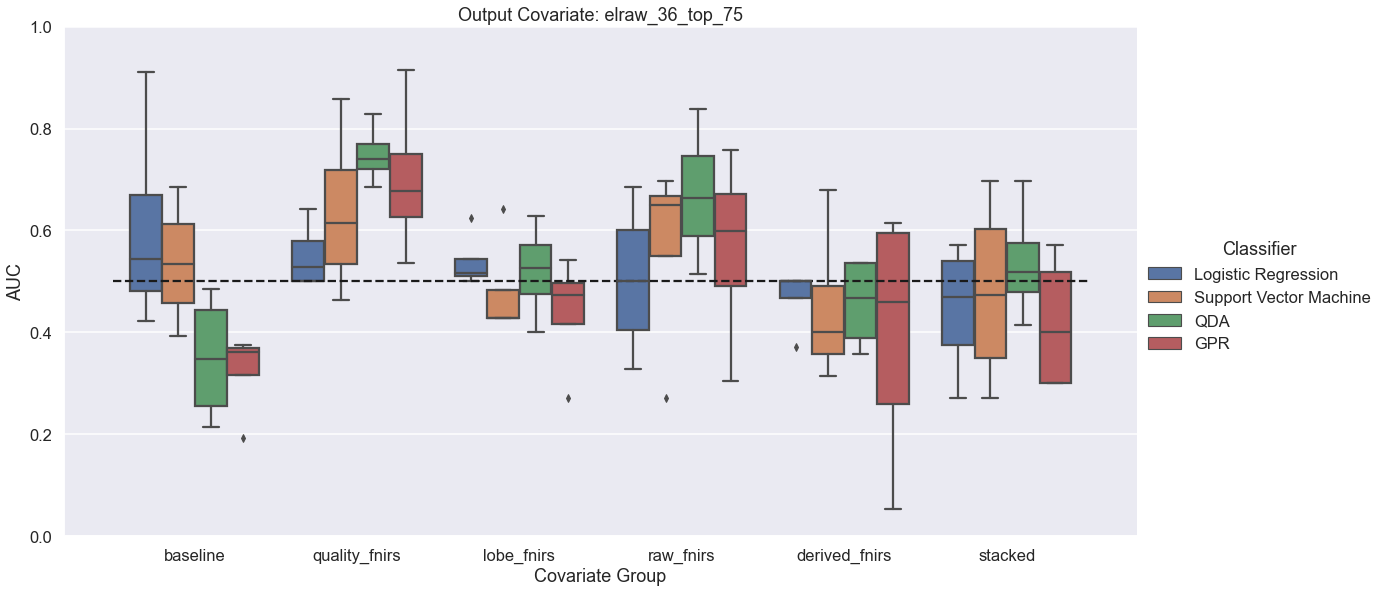

<Figure size 1152x720 with 0 Axes>

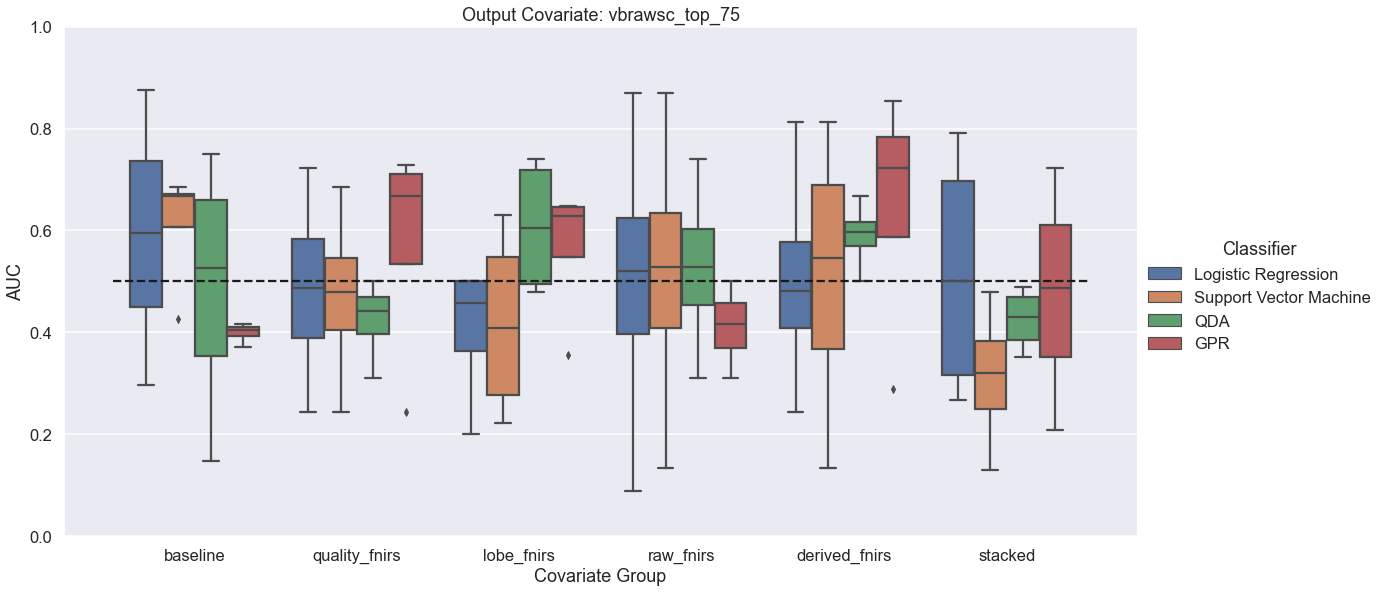

<Figure size 1152x720 with 0 Axes>

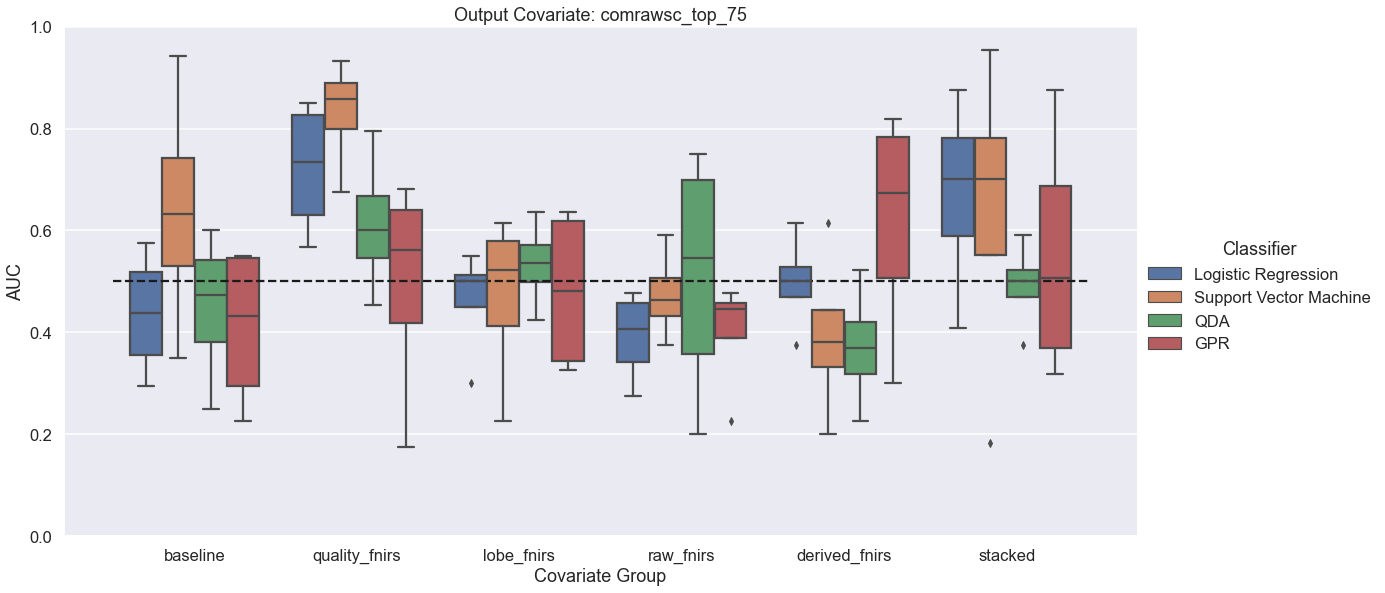

In [224]:
for output_variable in all_results.keys():
    results, outer_cv, df_displays = all_results[output_variable]
    for df in df_displays:
        df['model'] = df.index.name

    df = pd.concat(df_displays, 0).reset_index()
    df.columns = ['Covariate Group', 'Average AUROC (over 4 folds)', 'Standard Deviation AUROC (over 4 folds)', 'Classifier']

    def grouped_barplot(df, cat, subcat, val, err, title):
        u = df[cat].unique()
        x = np.arange(len(u))
        subx = df[subcat].unique()
        offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
        width= np.diff(offsets).mean()
        for i, gr in enumerate(subx):
            dfg = df[df[subcat] == gr]
            plt.bar(x+offsets[i], dfg[val].values, width=width, 
                    label="{}: {}".format(subcat, gr), yerr=dfg[err].values)
        plt.plot([-0.5, 5.5], [0.5, 0.5], '--', c='k', label='Random Performance')
        plt.xlabel(cat)
        plt.ylim(0, 1)
        plt.ylabel(val)
        plt.xticks(x, u)
        plt.legend()
        plt.title(title)
        plt.show()

    plt.figure(figsize=(16, 10))
    auc = []
    model = []
    feature_names = []
    for key, value in results.items():
        model += [key] * 6 * 4
        x = value['test_score']
        auc += list(x[0, :])
        auc += list(x[1, :])
        auc += list(x[2, :])
        auc += list(x[3, :])
        feature_names += ['baseline', 'quality_fnirs', 'lobe_fnirs', 'raw_fnirs', 'derived_fnirs', 'stacked'] * 4

    df_boxplot = pd.DataFrame({
        'Classifier': model,
        'AUC': auc,
        'Covariate Group': feature_names
    })

    title=f'Output Covariate: {output_variable}'
    sns.catplot(x="Covariate Group", y="AUC", hue="Classifier",  data=df_boxplot, kind="box", dodge=True, height=8, aspect=2);
    plt.plot([-0.5, 5.5], [0.5, 0.5], '--', c='k', label='Random Performance');
    plt.ylim(0, 1)
    plt.title(title)
    #grouped_barplot(df, df.columns[0], df.columns[3], df.columns[1], df.columns[2], title=title)

In [ ]:
# rlraw_24_top_75 has high performance for both SVM and logistic regression. what are these coefficients?
results, outer_cv, df_displays = all_results['rlraw_24_top_75']

models = results["Logistic Regression"]["estimator"]

# for each model, we need to figure out: 
# (a) which columns were selected
# (b) which columns were appended from the imputer
# (c) which columns were dropped by the selector
# (d) coefficients of what's left

dfs = []
i = 1
covariate_index = names_of_covariate_groups.index('baseline')
for _, model in [i[covariate_index] for i in models]:

    column_selector = model.steps[0][1]
    imputer = model.steps[2][1]
    selector = model.steps[3][1]
    lr = model.steps[4][1]
    
    starting_cols = column_selector.cols
    
    if len(imputer.statistics_) != len(column_selector.cols):
        print('stuff had to be filled in!')
        
    selected_cols = np.array(starting_cols)[selector.get_support()]
    
    coefs = lr.coef_[0]
    
    df = pd.DataFrame({
        'Input Covariate': selected_cols,
        "Logistic Regression Coefficient (normalized)": coefs / np.max(coefs),
        'Split Number': [i] * len(coefs)
    })
    
    dfs.append(df)
    i += 1
    
df_all = pd.concat(dfs)

plt.figure(figsize=(10, 36))
sns.barplot(y = "Input Covariate", x = "Logistic Regression Coefficient (normalized)", hue = "Split Number", data = df_all)
plt.tight_layout()
plt.title("Logistic Regression Baseline Coefficients for Predicting rlraw_24_top_75")
plt.show()

In [ ]:
# there is also curiously high-quality performance for predicting comrawsc_top_75 from quality fnirs
# rlraw_24_top_75 has high performance for both SVM and logistic regression. what are these coefficients?
results, outer_cv, df_displays = all_results['comrawsc_top_75']

models = results["Logistic Regression"]["estimator"]

# for each SVM, we need to figure out: 
# (a) which columns were selected
# (b) which columns were appended from the imputer
# (c) which columns were dropped by the selector
# (d) coefficients of what's left

dfs = []
i = 1
covariate_index = names_of_covariate_groups.index('quality_fnirs')
for _, model in [i[covariate_index] for i in models]:

    column_selector = model.steps[0][1]
    imputer = model.steps[2][1]
    selector = model.steps[3][1]
    lr = model.steps[4][1]
    
    starting_cols = column_selector.cols
    
    if len(imputer.statistics_) != len(column_selector.cols):
        print('stuff had to be filled in!')
        
    selected_cols = np.array(starting_cols)[selector.get_support()]
    
    coefs = lr.coef_[0]
    
    df = pd.DataFrame({
        'Input Covariate': selected_cols,
        "Logistic Regression Coefficient (normalized)": coefs / np.nanmax(coefs),
        'Split Number': [i] * len(coefs)
    })
    
    dfs.append(df)
    i += 1
    
df_all = pd.concat(dfs)


plt.figure(figsize=(16, 66))
sns.barplot(y = "Input Covariate", x = "Logistic Regression Coefficient (normalized)", hue = "Split Number", data = df_all)
plt.tight_layout()
plt.title("Logistic Regression fNIRS Quality Coefficients for Predicting comrawsc_top_75")
plt.show()